<a href="https://colab.research.google.com/github/lorenafc/Capita_Selecta_RHI50403/blob/main/Maps_authors_NL_BE_UK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install libraries
!pip install cartopy -q
!pip install contextily -q
!pip install pyproj -q
!pip install matplotlib-scalebar -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 16.8 MB/s eta 0:00:00


In [2]:
#import libraries
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
import os
import imageio
import random
import numpy as np
import re

from pyproj import Geod
from moviepy.editor import ImageSequenceClip
from shapely.geometry import Point, LineString
import matplotlib.colors as mcolors
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches


In [3]:
# import and mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [54]:
file_name = 'additional_authors_complete_geocoded_GoogleAPI_drive.xlsx'
authors_small_cities = pd.read_excel(file_name, engine='openpyxl')

In [55]:
file_name_ns = 'belgiumnetherlandsuk.xlsx'
north_sea = pd.read_excel(file_name_ns, engine='openpyxl')



In [56]:
# Load the shapefiles
netherlands = gpd.read_file('nl.shp').to_crs(epsg=3857)
belgium = gpd.read_file('uk.shp').to_crs(epsg=3857)
uk = gpd.read_file('be.shp').to_crs(epsg=3857)

In [57]:
# Combine the shapefiles into a single GeoDataFrame
combined_shapefile = pd.concat([netherlands, belgium, uk])

In [58]:
authors_small_cities = authors_small_cities.rename(columns={'bitrhyear': 'birthyear'})

In [59]:
# Create GeoSeries for birth, death, and active points
birth_points = gpd.GeoSeries([Point(xy) if pd.notnull(xy[0]) and pd.notnull(xy[1]) else None
                              for xy in zip(authors_small_cities['longitude_born'], authors_small_cities['latitude_born'])], crs="EPSG:4326")
death_points = gpd.GeoSeries([Point(xy) if pd.notnull(xy[0]) and pd.notnull(xy[1]) else None
                              for xy in zip(authors_small_cities['longitude_death'], authors_small_cities['latitude_death'])], crs="EPSG:4326")
active_points = gpd.GeoSeries([Point(xy) if pd.notnull(xy[0]) and pd.notnull(xy[1]) else None
                               for xy in zip(authors_small_cities['longitude_active'], authors_small_cities['latitude_active'])], crs="EPSG:4326")

# Combine birth, death, and active points into a single GeoSeries, prioritizing death points first, then active points, and finally birth points
combined_points = death_points.fillna(active_points).fillna(birth_points)

# Now create a GeoDataFrame using the combined geometry column
authors_small_cities_combined = gpd.GeoDataFrame(authors_small_cities, geometry=combined_points)
authors_small_cities_combined = authors_small_cities_combined[authors_small_cities_combined.geometry.notnull()]

# Adjust the years: prioritize death year, if missing, use birth year + 60
# Convert 'birthyear' to numeric, coerce errors to NaN
authors_small_cities_combined['birthyear'] = pd.to_numeric(authors_small_cities_combined['birthyear'], errors='coerce')
authors_small_cities_combined['effective_year'] = authors_small_cities_combined['deathyear'].fillna(authors_small_cities_combined['birthyear'] + 60)

# Set the CRS for the new GeoDataFrame
authors_small_cities_combined = authors_small_cities_combined.set_crs("EPSG:4326").to_crs(epsg=3857)

# Filter the DataFrame from 800 to 1800
authors_small_cities_combined = authors_small_cities_combined[
    (authors_small_cities_combined['effective_year'] >= 800) & (authors_small_cities_combined['effective_year'] <= 1800)
].copy()

In [62]:
# Spatial join to filter points within the combined shapefile
authors_within_boundaries = gpd.sjoin(authors_small_cities_combined, combined_shapefile, op='within')


  if (await self.run_code(code, result,  async_=asy)):



In [63]:
# Convert to GeoDataFrame
northsea_gdf = gpd.GeoDataFrame(
    north_sea, geometry=gpd.points_from_xy(north_sea.longitude, north_sea.latitude), crs="EPSG:4326"
)

# Convert to Web Mercator projection
northsea_gdf = northsea_gdf.to_crs(epsg=3857)

In [64]:
# Create the 'year_plot' column for authors_within_boundaries (small cities)
authors_within_boundaries['year_plot'] = authors_within_boundaries['effective_year']

# Create the 'year_plot' column for northsea_gdf (big cities)
northsea_gdf['year_plot'] = northsea_gdf['finalcedate']


# Combine the two datasets by appending rows
combined_authors = pd.concat([authors_within_boundaries, northsea_gdf], ignore_index=True) ## I decided to leave the original columns names of the other spreadsheets and combined only the year columns



,indexauthor,starturl,birthyear,deathyear,nameandbirthdeathyear,georeferenceurl,borncity,deathcity,activecity,latitude_born,...,cleaneddeath.1,imputeddeath,finalcedate,finalcityid,finalcedate.1,Unnamed: 21,city.1,bairochcountry,latitude,longitude
0,101.0,http://viaf.org/viaf/305857998,1510.0,1582.0,"Arlenius, Arnoldus, 15..-15..",https://en.wikipedia.org/wiki/Arnoldus_Arlenius,Aarle Netherlands,NaN,NaN,51.512265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,337.0,http://viaf.org/viaf/261660119,1622.0,1680.0,"Bornaeus, Everhardus, 1622-1680",viafprocessedfile,Aldeboarn,Bolsward,Garyp,53.048109,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,339.0,http://viaf.org/viaf/8596401,1690.0,1773.0,"Vegelin van Claerbergen, Jan (Johan), 1690-1773",www.wikidata.org/wiki/Q17275693#sitelinks-wiki...,Aldeboarn,NaN,NaN,53.048109,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,456.0,http://viaf.org/viaf/34800196,1644.0,1707.0,"Bayard, Nicholas, 1644?-1707",www.wikidata.org/wiki/Q508327#sitelinks-wikipedia,Alphen aan den Rijn,NaN,NaN,52.129373,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,480.0,http://viaf.org/viaf/49542284,1550.0,1582.0,"Popma, Cyprianus van, 1550-1582.",http://d-nb.info/gnd/129197394,Alst (IJlst)/Friesland,NaN,NaN,53.011359,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
# Save the spreadsheets that will be used to plot the maps
combined_authors.to_excel('northsea_combined_used_plot_maps.xlsx', index=False)
combined_authors.to_csv('northsea_combined_used_plot_maps.csv', index=False)



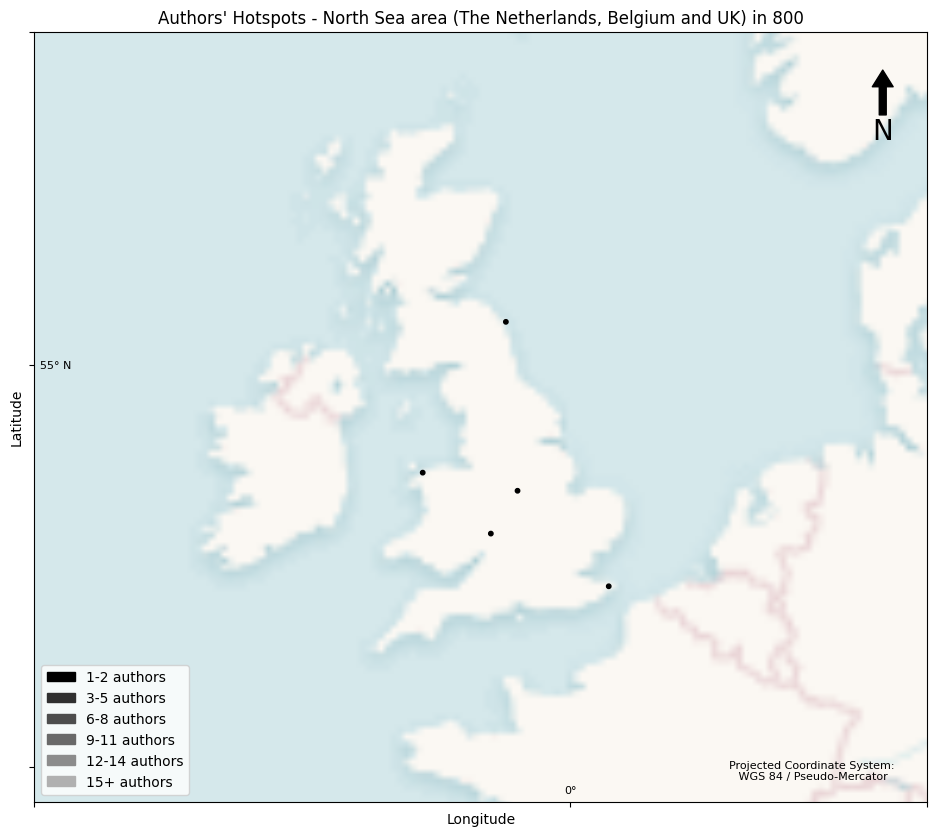

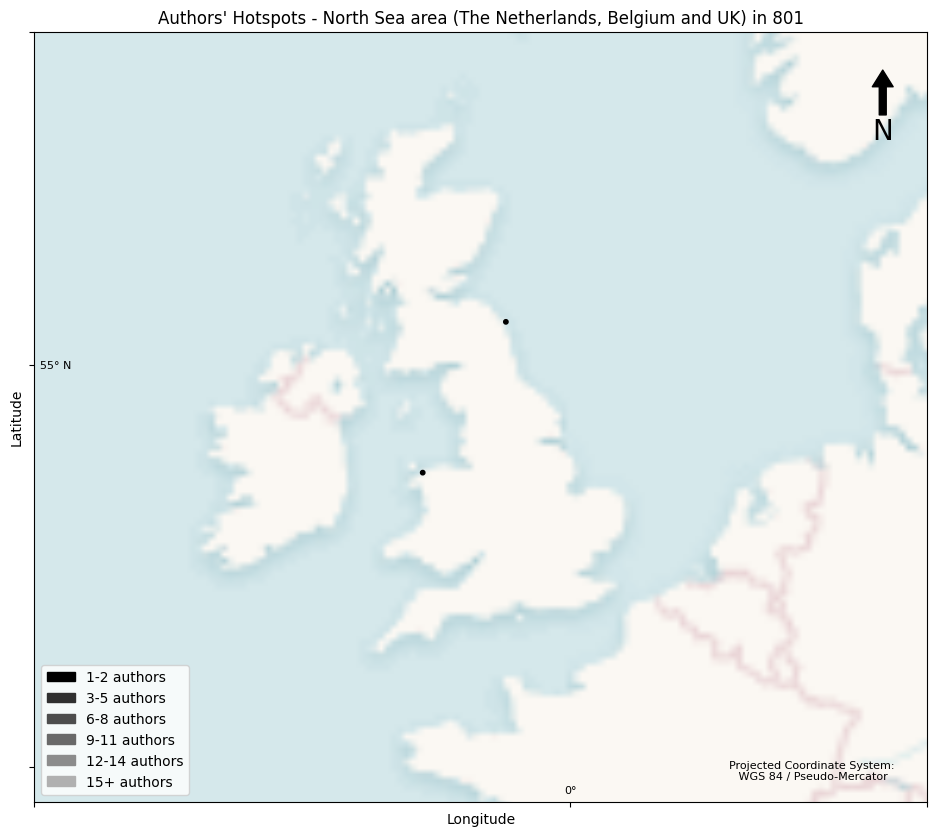

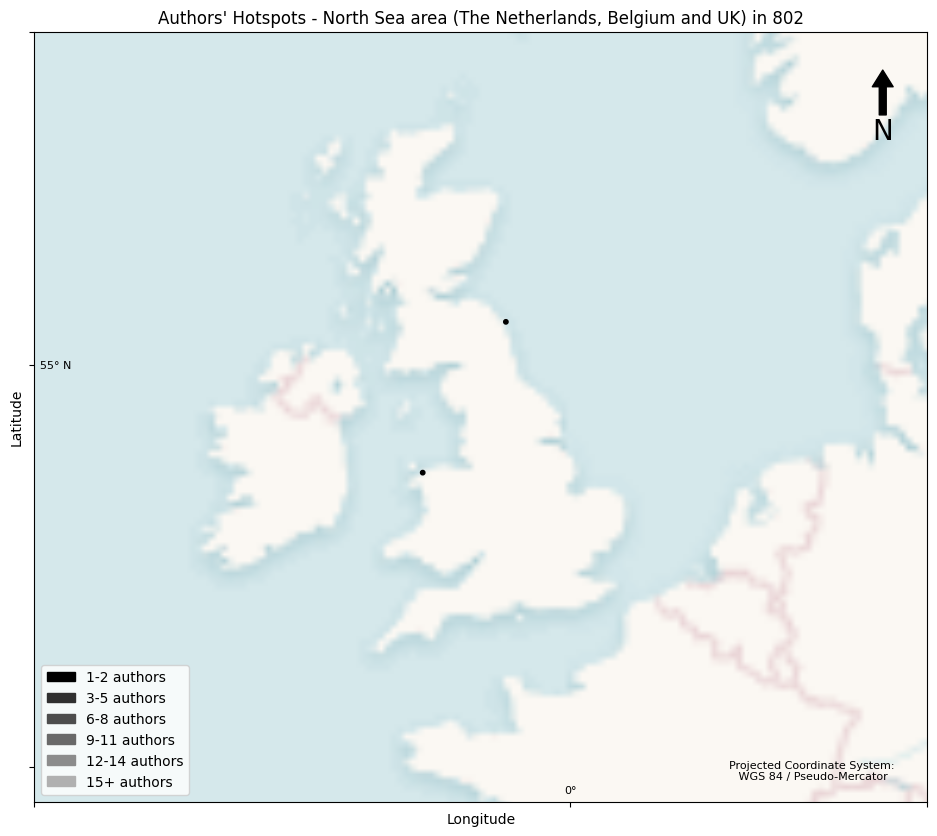

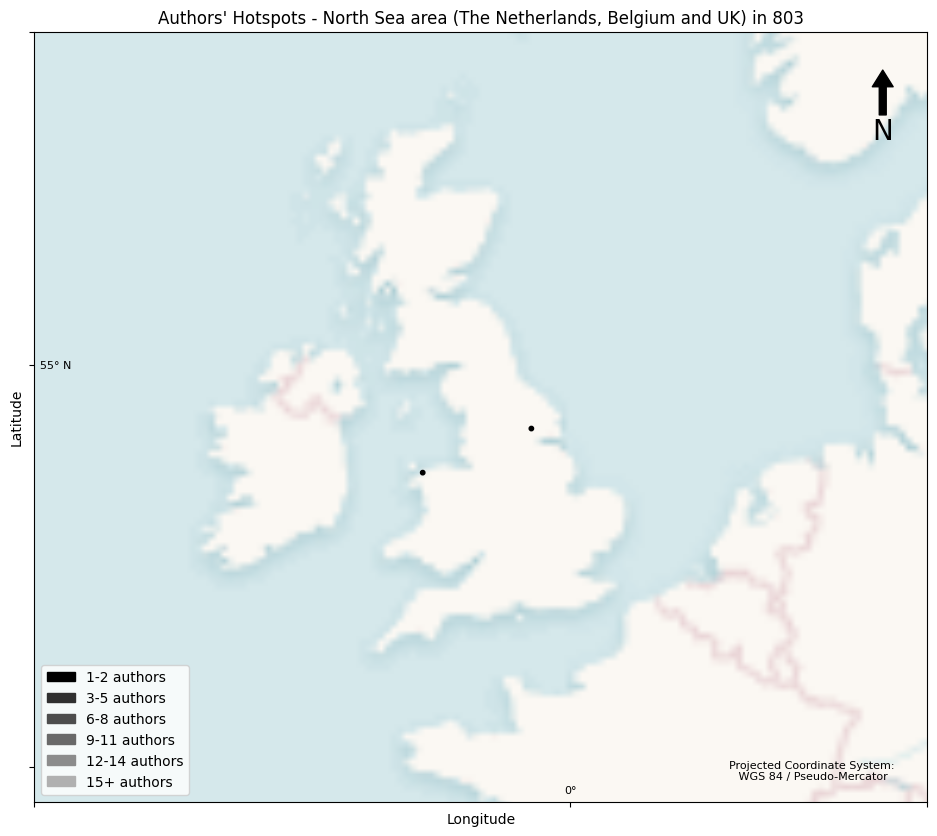

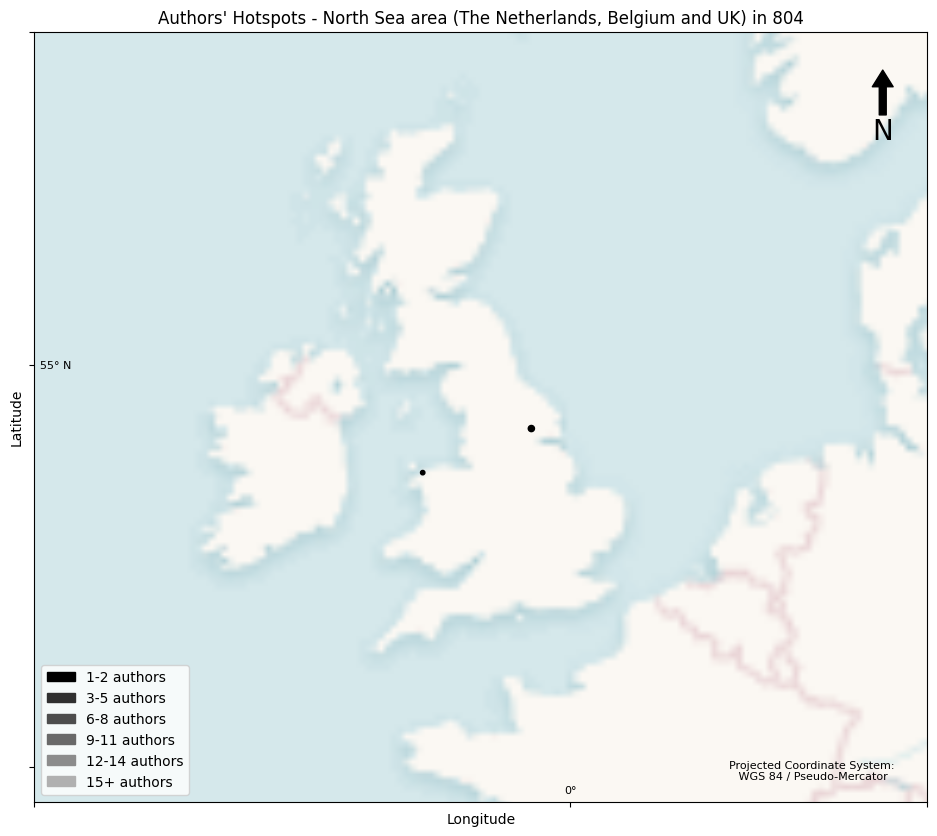

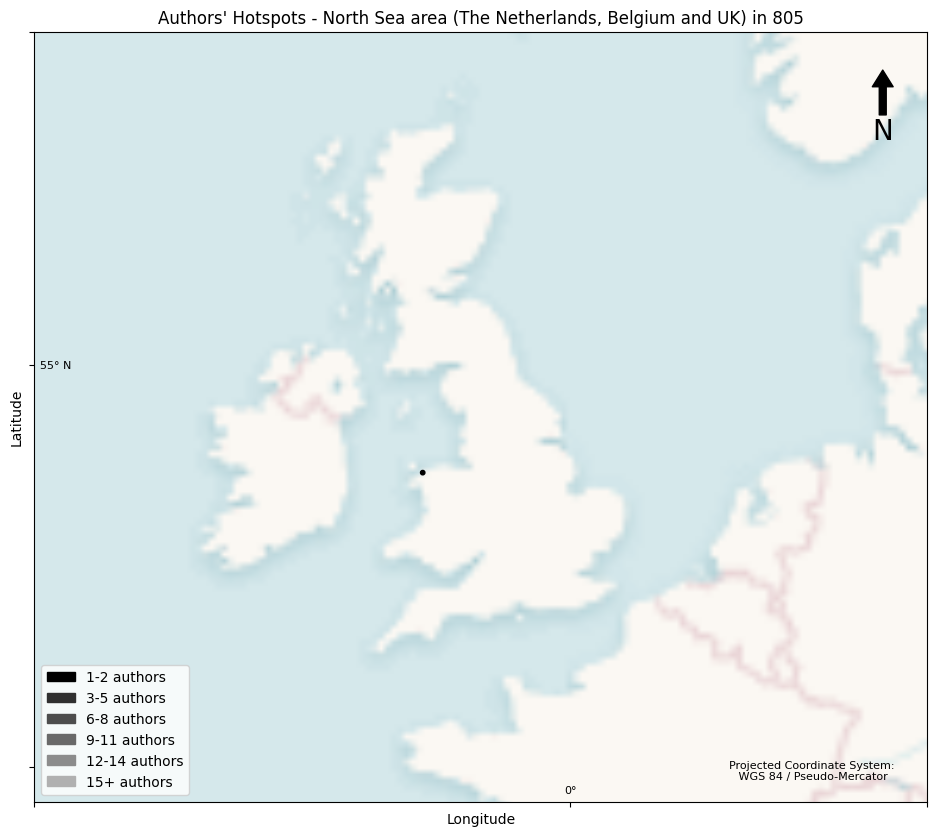

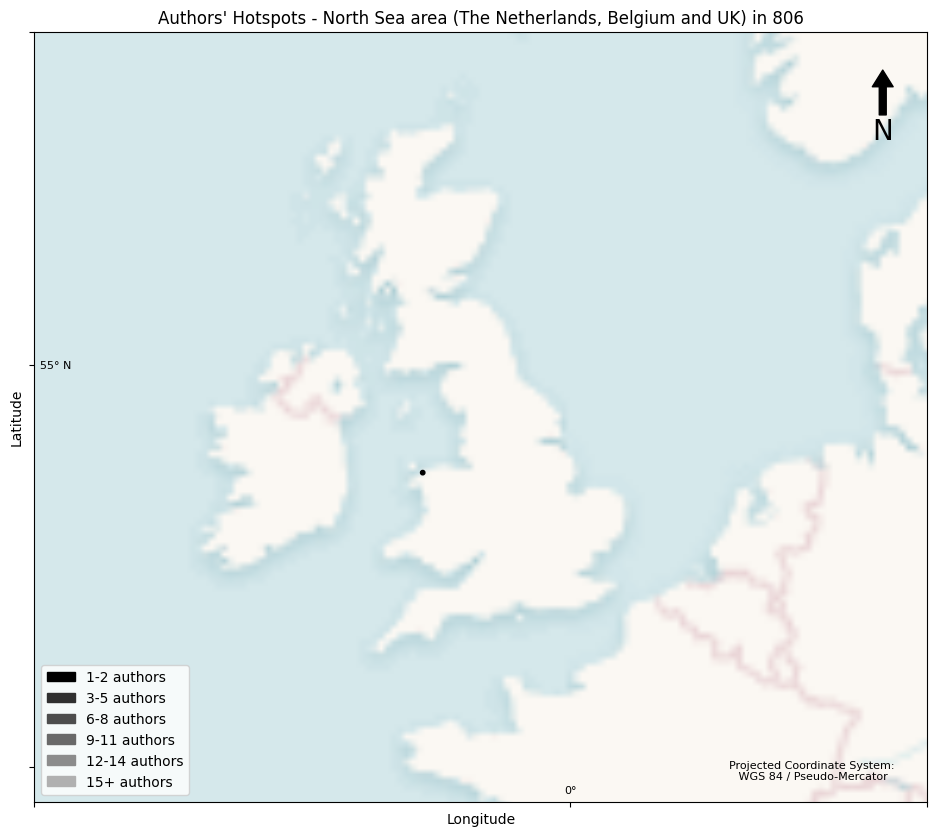

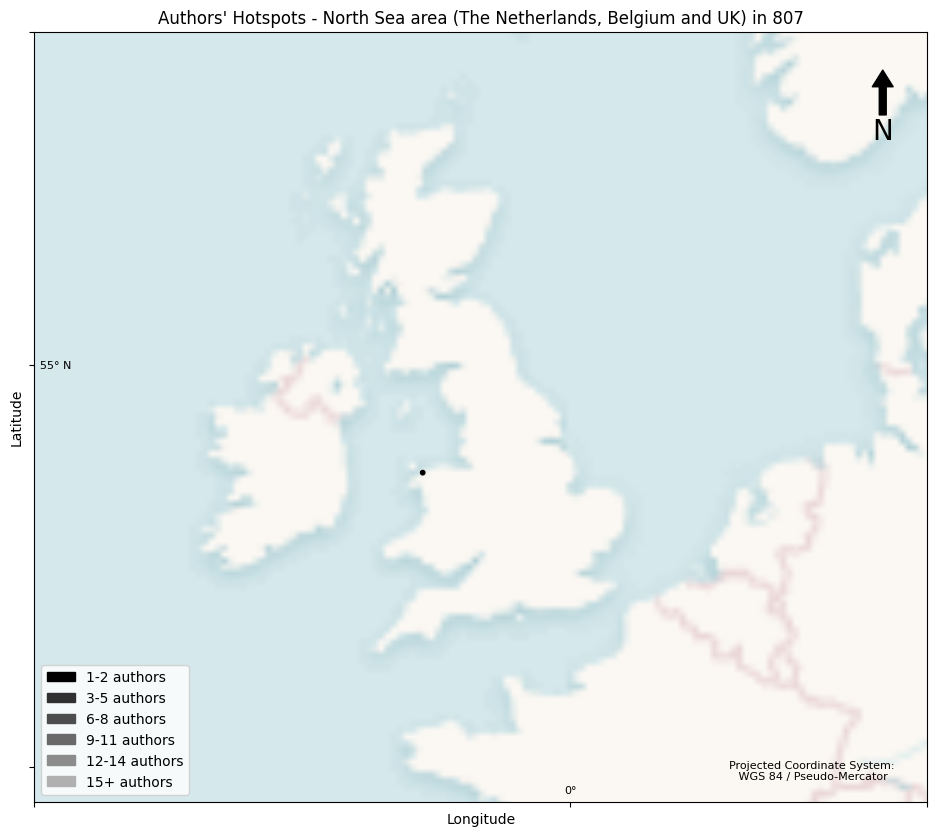

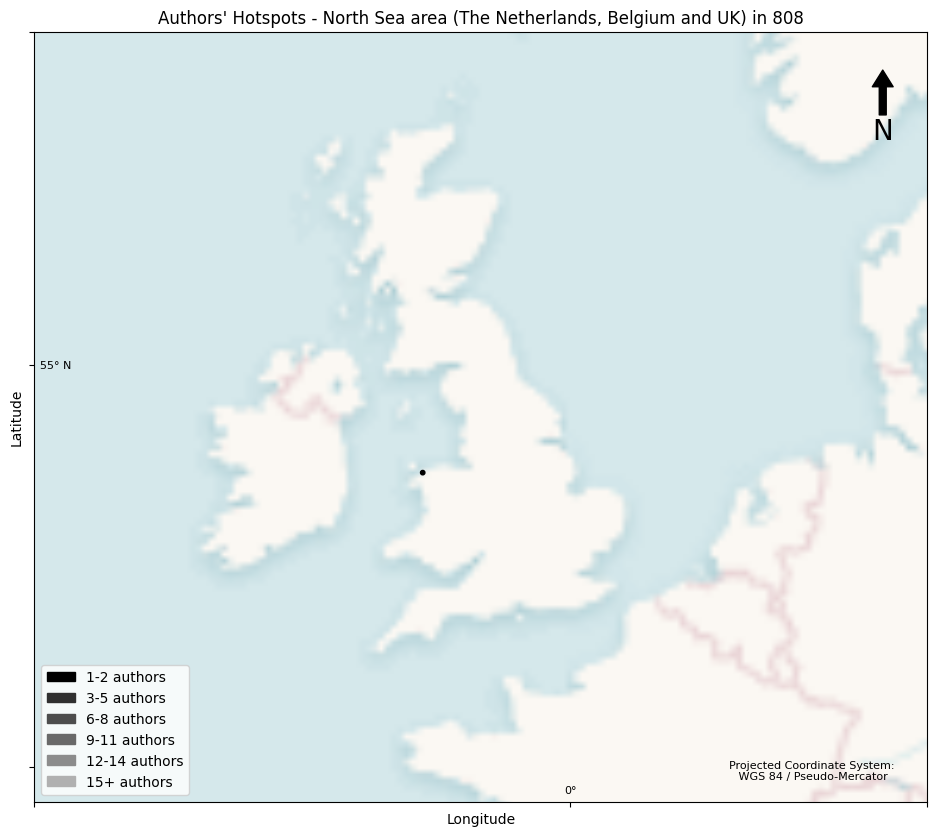

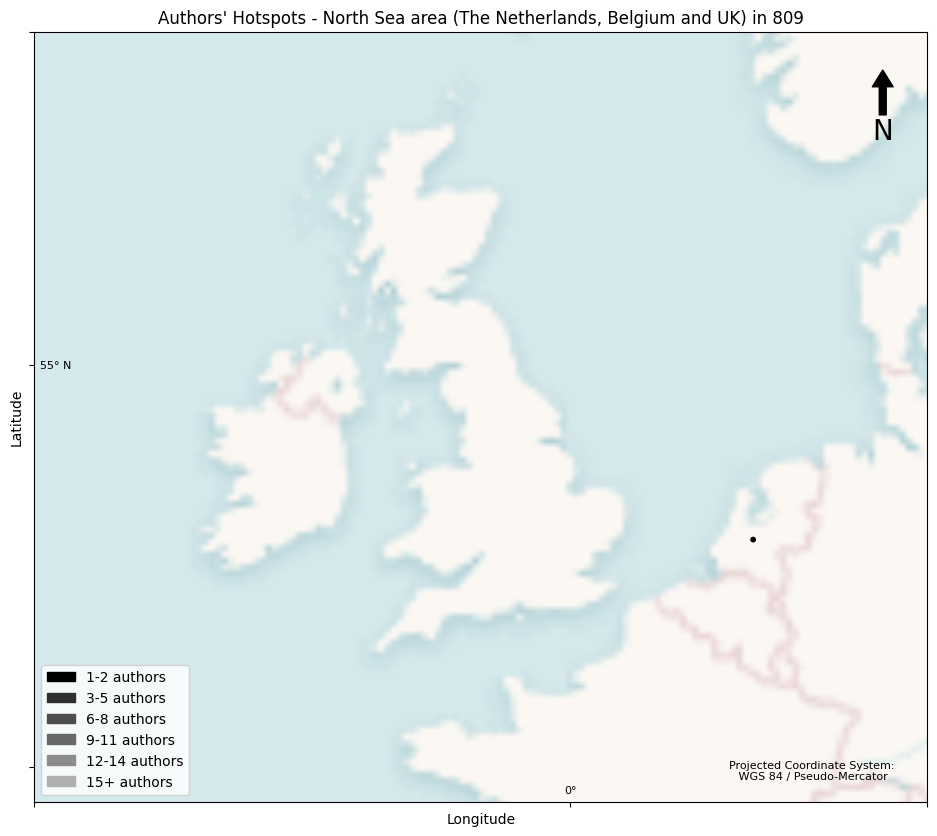

In [69]:
# source: chatGPT and Lucas Koren

# Define the start and end years
startyear = 800
endyear = 809
step = 1

output_images_dir = "/content/drive/My Drive/capita_selecta/nlbeuk/"
os.makedirs(output_images_dir, exist_ok=True)

# The Netherland boundaries in Web Mercator projection
world_bounds = [0, 6000000, 837000, 7500000]

# Invisible points to ensure full basemap is displayed
invisible_points = gpd.GeoDataFrame({
    'geometry': [
        Point(-20037508.34, -20037508.34),  # Bottom left
        Point(20037508.34, -20037508.34),   # Bottom right
        Point(-20037508.34, 20037508.34),   # Top left
        Point(20037508.34, 20037508.34)     # Top right
    ],
    'point_count': [0, 0, 0, 0]
}, crs="EPSG:3857")

# Define a custom color map with inverted greyscale
cmap = mcolors.ListedColormap(['#000000', '#303030', '#4D4D4D', '#696969', '#8C8C8C', '#B0B0B0'])
bounds = [1, 3, 6, 9, 12, 15]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Function to determine opacity
def get_opacity(count):
    if count >= 15:
        return 0.4
    elif count >= 9:
        return 0.6
    else:
        return 1.0

# Function to plot maps for each year
def plot_maps_per_year(startyear, endyear, combined_authors, northsea_gdf):
    for year in range(startyear, endyear + 1):
        # Filter the GeoDataFrame for authors active in the timestep for 10 years prior to their death
        # using the new unified 'year_plot' column
        authors_active_timestep = combined_authors[
            (combined_authors['year_plot'] > year) &
            (combined_authors['year_plot'] <= year + 10)
        ]

        # Filter the northsea GeoDataFrame for points in the current year
        northsea_active_timestep = northsea_gdf[northsea_gdf['year_plot'] == year]

        # Combine both GeoDataFrames
        combined_active_timestep = pd.concat([authors_active_timestep, northsea_active_timestep])


        # Check if there are any valid records for the current year
        if not combined_active_timestep.empty:
            # Create a point_count column
            combined_active_timestep['point_count'] = 1

            # Group by unique points and get the count for each group and turn into GeoDataFrame  # source: https://sparkbyexamples.com/pandas/pandas-groupby-sum-examples/
            unique_points_gdf = combined_active_timestep.groupby('geometry').agg({'point_count': 'sum'}).reset_index()

            # Ensure the CRS is set to EPSG:3857 for latitude and longitude
            unique_points_gdf = gpd.GeoDataFrame(unique_points_gdf, geometry='geometry', crs='EPSG:3857')

            # Add invisible points to ensure full basemap is displayed
            unique_points_gdf = pd.concat([unique_points_gdf, invisible_points], ignore_index=True)

            # Add opacity column based on the point_count
            unique_points_gdf['opacity'] = unique_points_gdf['point_count'].apply(get_opacity)


            # Plotting
            fig, ax = plt.subplots(figsize=(19, 10))

            # Plotting the points
            unique_points_gdf.plot(
                ax=ax,
                column='point_count',
                cmap=cmap,
                norm=norm,
                markersize=unique_points_gdf['point_count']*10,
                alpha=unique_points_gdf['opacity'],
                edgecolor='black'
            )

            # Add basemap with fixed zoom level
            cx.add_basemap(ax, attribution=False, zoom=3, crs=unique_points_gdf.crs.to_string(), source=cx.providers.CartoDB.VoyagerNoLabels)
            # Setting the bounds
            ax.set_xlim(world_bounds[0], world_bounds[2])
            ax.set_ylim(world_bounds[1], world_bounds[3])

            # Set title and axis labels
            ax.set_title(f"Authors' Hotspots - North Sea area (The Netherlands, Belgium and UK) in {year}")
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')

            ax.set_xticks([-1669792, 0, 1113194])
            ax.set_xticklabels(['', '0°', ''])

            ax.set_yticks([6106854, 7361866, 8399737.88])
            ax.set_yticklabels(['', '55° N', ''])

            # Adjust position of tick labels
            ax.tick_params(axis='x', pad=-15, labelsize=8)
            ax.tick_params(axis='y', pad=-30, labelsize=8)

            # Adicione uma anotação
            ax.annotate("Projected Coordinate System:\n WGS 84 / Pseudo-Mercator", xy=(0.87,0.04), ha= "center", va="center", fontsize=8, xycoords= ax.transAxes)



            legend_handles = [
                mpatches.Patch(color="#000000", label="1-2 authors"),
                mpatches.Patch(color="#303030", label="3-5 authors"),
                mpatches.Patch(color="#4D4D4D", label="6-8 authors"),
                mpatches.Patch(color="#696969", label="9-11 authors"),
                mpatches.Patch(color="#8C8C8C", label="12-14 authors"),
                mpatches.Patch(color="#B0B0B0", label="15+ authors")
            ]


            # Add the legend to the plot
            ax.legend(handles=legend_handles, loc='lower left')

            x, y, arrow_length = 0.95, 0.95, 0.08
            ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                        arrowprops=dict(facecolor='black', width=5, headwidth=15),
                        ha='center', va='center', fontsize=20,
                        xycoords=ax.transAxes)

            # Saving the plot as an image
            output_image_path = os.path.join(output_images_dir, f'active_north_sea_{year}.png')
            plt.savefig(output_image_path)
            plt.close(fig)
            # plt.show()

# Plot maps per year
plot_maps_per_year(startyear, endyear, authors_within_boundaries, northsea_gdf)


## Gif and Video - NL X BE X UK

In [ ]:
### Create the gifs and video
#source: https://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python and chat gpt

# Function to extract numerical values from filenames
def extract_number(file_name):
    match = re.search(r'(\d+)', file_name)
    return int(match.group(0)) if match else -1

# Path to the directory containing the images
image_dir = "/content/drive/My Drive/capita_selecta/nlbeuk/" #update your path

# Check if the directory exists
if not os.path.exists(image_dir):
    print(f"The directory {image_dir} does not exist.")
else:
    print(f"Directory {image_dir} exists. Proceeding with file processing.")

    # List all the image files in the directory
    image_files = sorted(
        [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.png')],
        key=lambda x: extract_number(os.path.basename(x))
    )

    # Ensure the list is not empty
    if not image_files:
        print("No images found in the specified directory.")
    else:
        # Create a GIF (the gif works with 500 images but not with all of them on colab. I used VS code to make the gif with all the images from 800 to 1800)
        # gif_output_path = os.path.join(image_dir, 'authors_active_europe.gif')
        # images = [imageio.imread(file) for file in image_files]
        # imageio.mimsave(gif_output_path, images, fps=30, loop=0)  # Adjust fps as needed
        # print(f"GIF saved at {gif_output_path}")

        # Create a video
        video_output_path = os.path.join(image_dir, 'video_authors_active_NL_BE_UK_googleapi.mp4')
        clip = ImageSequenceClip(image_files, fps=30)  # Adjust fps as needed
        clip.write_videofile(video_output_path, codec='libx264')
        print(f"Video saved at {video_output_path}")


Directory /content/drive/My Drive/capita_selecta/nlbeuk_19/ exists. Proceeding with file processing.
Moviepy - Building video /content/drive/My Drive/capita_selecta/nlbeuk_19/video_authors_active_NL_BE_UK_googleapi.mp4.
Moviepy - Writing video /content/drive/My Drive/capita_selecta/nlbeuk_19/video_authors_active_NL_BE_UK_googleapi.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/My Drive/capita_selecta/nlbeuk_19/video_authors_active_NL_BE_UK_googleapi.mp4
Video saved at /content/drive/My Drive/capita_selecta/nlbeuk_19/video_authors_active_NL_BE_UK_googleapi.mp4
